# Contents

- Load dependancies
- Understanding Dicom's
- Pixel distribution and Tissue densitites
- EDA
- Looking at patient ID00082637202201836229724
    - viewing the slices in chronological order
- Next Steps

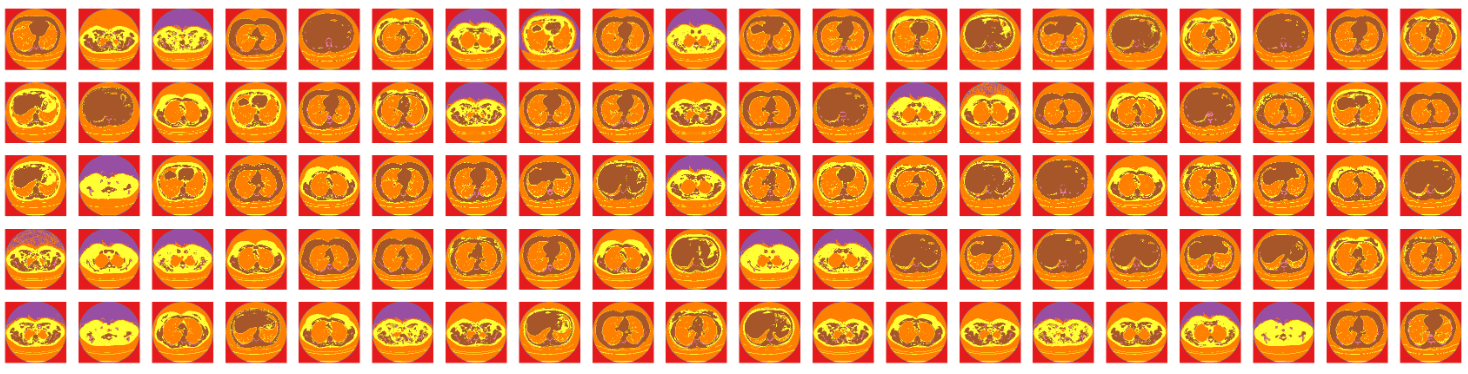

DICOM(Digital Imaging and COmmunications in Medicine) is the de-facto standard that establishes rules that allow medical images(X-Ray, MRI, CT) and associated information to be exchanged between imaging equipment from different vendors, computers, and hospitals.

DICOM files typically have a .dcm extension and provides a means of storing data in separate 'tags' such as patient information as well as image/pixel data. A DICOM file consists of a header and image data sets packed into a single file. The information within the header is organized as a constant and standardized series of tags.

By extracting data from these tags one can access important information regarding the patient demographics, study parameters, etc

This competition specifically uses CT scans

If you are interested in knowing more about medical imaging you can view my [blog](https://asvcode.github.io/MedicalImaging/)

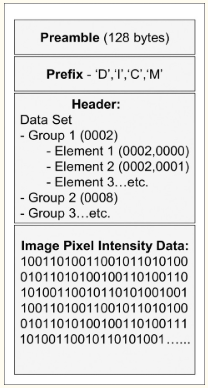

To access the files I will be using `fastai2.medical.imaging module`.  Under the hood `fastai` uses `pydicom` to access the dicom files.

Pydicom is a python package for parsing DICOM files and makes it easy to covert DICOM files into pythonic structures for easier manipulation. Files are opened using pydicom.dcmread

# Load Dependancies

In [1]:
!pip install fastai2 -q

In [2]:
#Load the dependancies
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom
import seaborn as sns

import numpy as np
import pandas as pd
import os

sns.set(style="whitegrid")
sns.set_context("paper")

In [3]:
source = Path('../input/osic-pulmonary-fibrosis-progression')
files = os.listdir(source)
print(files)

['test', 'sample_submission.csv', 'test.csv', 'train.csv', 'train']


Specify the folder that contains the training images train and use `get_dicom_files` to access the dicom images

In [4]:
train = source/'train'
train_files = get_dicom_files(train)
train_files

(#33026) [Path('../input/osic-pulmonary-fibrosis-progression/train/ID00210637202257228694086/89.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00210637202257228694086/271.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00210637202257228694086/32.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00210637202257228694086/251.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00210637202257228694086/287.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00210637202257228694086/3.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00210637202257228694086/261.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00210637202257228694086/87.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00210637202257228694086/67.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00210637202257228694086/28.dcm')...]

There are `33026` files in the train set

# Understanding Dicom's

Now lets take a look the `header` section of the dicom image

In [13]:
info_view = train_files[777]
dimg = dcmread(info_view)
dimg

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.103029579892839773441453512373877707862
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0018) SOP Instance UID                    UI: 2.25.103029579892839773441453512373877707862
(0008, 0060) Modality                            CS: 'CT'
(0008, 0070

There are some 'key' aspects within the header:

**(0018, 0015) Body Part Examined CS: Chest**: images are from the chest area

**(0020, 0013) Instance Number IS: "420"**: this is the same as the `.dcm` image file

**(0020, 0032) Image Position (Patient) DS: [-182.800, -177.600, -165.000]**: represents the x, y and z positions

**(0020, 0037) Image Orientation (Patient) DS: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]**: This is 6 values that represent two normalized 3D vectors(in this case directions) where the first vector [1,0,0] represents Xx, Xy, Xz and the second vector [0,1,0] that represents Yx, Yy, Yz.

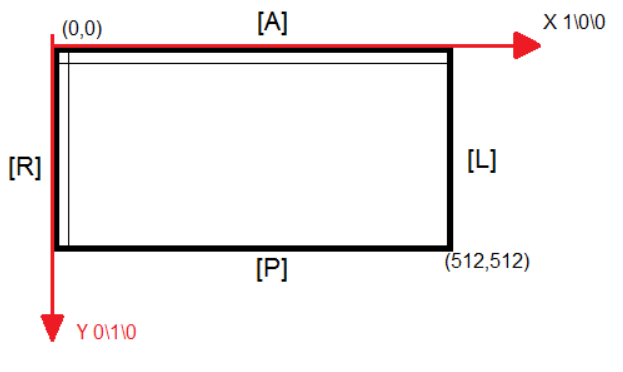
In this case the image plane is parallel to the patient Axial Plane [source](http://dicomiseasy.blogspot.com/2013/06/getting-oriented-using-image-plane.html)

**(0028, 0004) Photometric Interpretation CS: MONOCHROME2**: aka the colorspace, images are being stored as low values=dark, high values=bright. If the colorspace was **MONOCHROME** then the low values=bright and high values=dark.

**(0028, 0100) Bits Allocated US: 16**: each image is 16 bits

**(0028, 1050) Window Center DS: "-500.0"**   : aka Brightness

**(0028, 1051) Window Width  DS: "-1500.0"**  : aka Contrast  

**(0028, 1052) Rescale Intercept DS: "-1024.0"** and **(0028, 1053) Rescale Slope DS: "1.0"**: The Rescale Intercept and Rescale Slope are applied to transform the pixel values of the   image into values that are meaningful to the application. It's importance is explained further in the kernel.

**(7fe0, 0010) Pixel Data OW: Array of 524288 elements**: the image pixel data that `pydicom` uses to convert the pixel data into an image. 

This can be calculated by this formula: **Array of elements** = **Rows X Columns X Number of frames X Samples per pixel X (bits_allocated/8)** so in this example it would be **512 X 512 X 1 X 1 X (16/8) = 524288**


What does `Pixel Data` look like?

In [6]:
dimg.PixelData[:200]

b'0\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf40\xf4'

By default `pydicom` reads `PixelData` as the raw bytes. Because of the complexity in interpreting `PixelData`, `pydicom` provides an easy way to get it in a convenient form known as the `pixel_array` which returns a `numpy.ndarray` containing the `PixelData`

In [14]:
dimg.pixel_array, dimg.pixel_array.shape

(array([[-2000, -2000, -2000, ..., -2000, -2000, -2000],
        [-2000, -2000, -2000, ..., -2000, -2000, -2000],
        [-2000, -2000, -2000, ..., -2000, -2000, -2000],
        ...,
        [-2000, -2000, -2000, ..., -2000, -2000, -2000],
        [-2000, -2000, -2000, ..., -2000, -2000, -2000],
        [-2000, -2000, -2000, ..., -2000, -2000, -2000]], dtype=int16),
 (512, 512))

Taking a look at the the pixel data using the `show` function

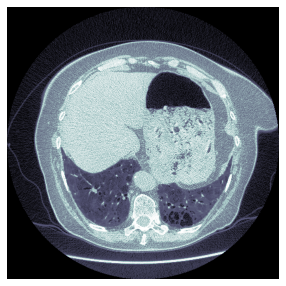

In [15]:
dimg.show()

# Pixel Distribution and Tissue Densities

These images are 16 bit DICOM images and typically the pixel values in these type of images can range from `-32768` to `32768`.

Looking at the pixel distribution of this image

(array([5.5772e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.5141e+04,
        1.5056e+04, 9.7258e+04, 1.8209e+04, 6.1800e+02, 9.0000e+01]),
 array([-2000. , -1556.3, -1112.6,  -668.9,  -225.2,   218.5,   662.2,
         1105.9,  1549.6,  1993.3,  2437. ], dtype=float32),
 <a list of 10 Patch objects>)

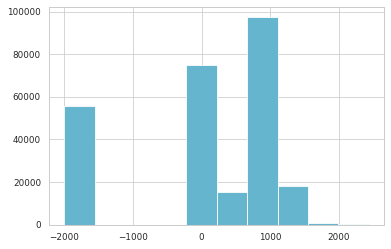

In [16]:
px = dimg.pixels.flatten()
plt.hist(px, color='c')

In this case the pixel distribution is from `-2000` to `2437` and as this image is stored in `MONOCHROME2` format the low values appear as dark and the high values as bright.

In [17]:
tensor_dicom = pixels(dimg) #convert into tensor

print(f'RescaleIntercept: {dimg.RescaleIntercept:1f}\nRescaleSlope: {dimg.RescaleSlope:1f}\nMax pixel: '
      f'{tensor_dicom.max()}\nMin pixel: {tensor_dicom.min()}\nShape: {tensor_dicom.shape}')

RescaleIntercept: -1024.000000
RescaleSlope: 1.000000
Max pixel: 2437.0
Min pixel: -2000.0
Shape: torch.Size([512, 512])


This image has a RescaleIntercept of -1024 and a RescaleSlope of 1. These two values allows for transforming pixel values into [Hounsfield Units(HU)](https://en.wikipedia.org/wiki/Hounsfield_scale). Densities of different tissues on CT scans are measured in HUs

The Hounsfield scale is a quantitative scale for describing radiodensity in medical CT and provides an accurate density for the type of tissue. On the Hounsfield scale, air is represented by a value of −1000 (black on the grey scale) and bone between +300 (cancellous bone) to +3000 (dense bone) (white on the grey scale), water has a value of 0 HUs and metals have a much higher HU range +2000 HUs.

The pixel values in the histogram above do not correctly correspond to tissue densities. For example most of the pixels are between pixel values 0 and 200 which correspond to water but this image is predominantly showing the lungs which are filled with air. Air on the Hounsfield scale is -1000 HUs.

This is where RescaleIntercept and RescaleSlope are important. Fastai provides a convenient way by using a function `scaled_px` to rescale the pixels with respect to RescaleIntercept and RescaleSlope.

### rescaled pixel = pixel * RescaleSlope + RescaleIntercept

(array([5.5772e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 7.5141e+04,
        1.5056e+04, 9.7258e+04, 1.8209e+04, 6.1800e+02, 9.0000e+01]),
 array([-3024. , -2580.3, -2136.6, -1692.9, -1249.2,  -805.5,  -361.8,
           81.9,   525.6,   969.3,  1413. ], dtype=float32),
 <a list of 10 Patch objects>)

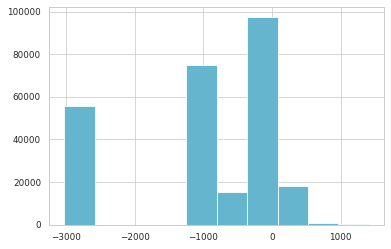

In [18]:
tensor_dicom_scaled = scaled_px(dimg) #convert into tensor taking RescaleIntercept and RescaleSlope into consideration
plt.hist(tensor_dicom_scaled.flatten(), color='c')

In [12]:
print(f'Max pixel: {tensor_dicom_scaled.max()}\nMin pixel: {tensor_dicom_scaled.min()}')

Max pixel: 2492.0
Min pixel: -3674.0


After re-scaling the maximum pixel value is 2492 and the minimum value is -3674 and we can now correctly see what parts of the image correspond to what parts of the body based on the Hounsfield scale.

### Looking at various densities

Looking at the bones `+300 HUs`

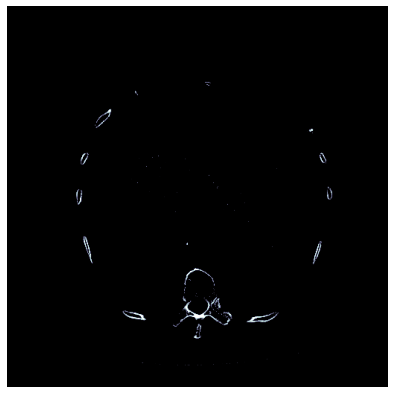

In [21]:
dimg.show(max_px=None, min_px=300, figsize=(7,7))

Looking at the water based areas `0 HUs`

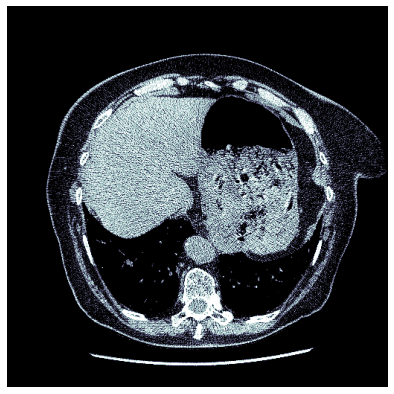

In [22]:
dimg.show(max_px=100, min_px=-100, figsize=(7,7))

Looking at the air filled areas `-1000 HUs`

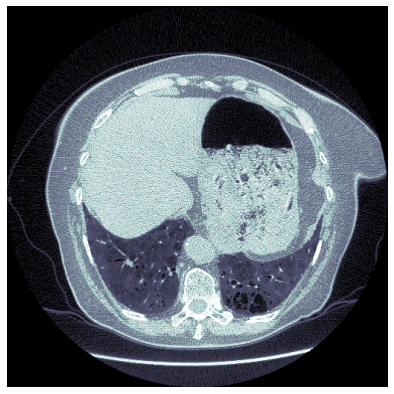

In [23]:
dimg.show(max_px=None, min_px=-1000, figsize=(7,7))

You can even view the CT chamber

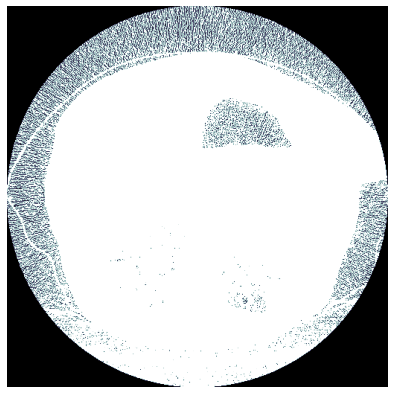

In [24]:
dimg.show(max_px=-1000, min_px=-2000, figsize=(7,7))

Create a function to view an image and some header `tags`

In [25]:
def show_one_image(file):
    """ function to view patient image and choosen tags within the head of the DICOM"""
    pat = dcmread(file)
    print(f'Patient ID: {pat.PatientID}')
    print(f'File Number: {pat.InstanceNumber}')
    print(f'\nWindow Center: {pat.WindowCenter}')
    print(f'Window Width: {pat.WindowWidth}')
    print(f'Rescale Intercept: {pat.RescaleIntercept}')
    print(f'Rescale Slope: {pat.RescaleSlope}')
    print(f'Body part: {pat.BodyPartExamined}')
    img = dcmread(file)
    return img.show()

Patient ID: ID00221637202258717315571
File Number: 420

Window Center: -500.0
Window Width: -1500.0
Rescale Intercept: -1024
Rescale Slope: 1
Body part: Chest


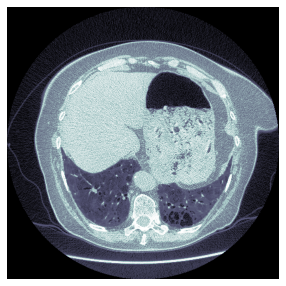

In [26]:
show_one_image(info_view)

# EDA

Taking a look at the `csv` file

In [27]:
df = pd.read_csv(source/'train.csv')
df.head()

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker

In [28]:
#Plot 3 comparisons
def plot_comparison3(df, feature, feature1, feature2):
    "Plot 3 comparisons from a dataframe"
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25, 4))
    s1 = sns.countplot(df[feature], ax=ax1)
    s1.set_title(feature)
    s2 = sns.countplot(df[feature1], ax=ax2)
    s2.set_title(feature1)
    s3 = sns.countplot(df[feature2], ax=ax3)
    s3.set_title(feature2)
    plt.show()

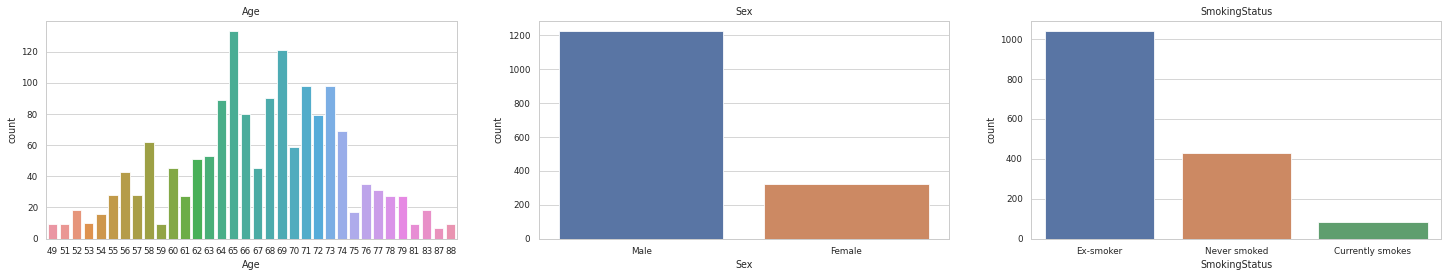

In [29]:
plot_comparison3(df, 'Age', 'Sex', 'SmokingStatus')

In [30]:
#Plot 1 comparisons
def plot_comparison1(df, feature):
    "Plot 1 comparisons from a dataframe"
    fig, (ax1) = plt.subplots(1,1, figsize = (25, 4))
    s1 = sns.countplot(df[feature], ax=ax1)
    s1.set_title(feature)
    plt.show()

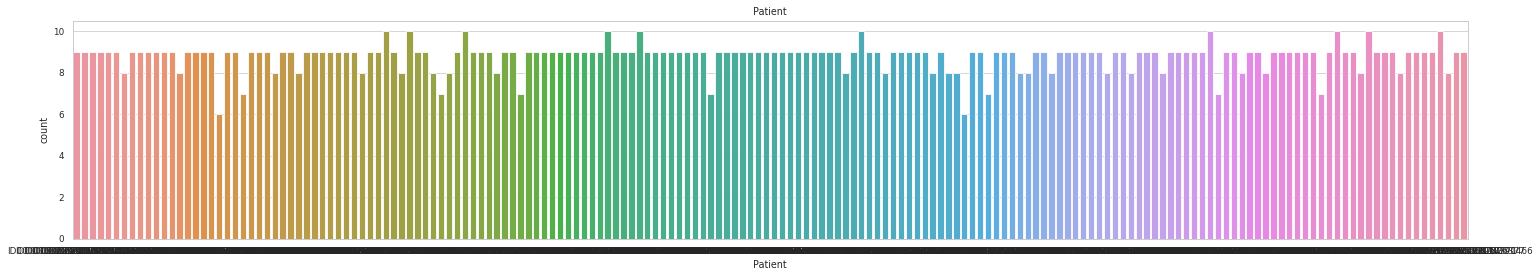

In [31]:
plot_comparison1(df, 'Patient')

In [32]:
no_of_patients = df.Patient.nunique()
no_of_patients

176

There are a total of `176` unique patients and each patient has between `6` and `10` visits logged in the csv file

# Looking at patient ID00082637202201836229724

Taking a look at patient: `ID00082637202201836229724`, there are 9 entries ranging from week 19 to week 79

In [33]:
patient_01 = df[df.Patient == 'ID00082637202201836229724']
patient_01

Patient  Weeks   FVC     Percent  Age     Sex  \
288  ID00082637202201836229724     19  2918   99.794802   49  Female   
289  ID00082637202201836229724     27  2955  101.060192   49  Female   
290  ID00082637202201836229724     29  2873   98.255814   49  Female   
291  ID00082637202201836229724     31  2963  101.333789   49  Female   
292  ID00082637202201836229724     33  2885   98.666211   49  Female   
293  ID00082637202201836229724     39  2837   97.024624   49  Female   
294  ID00082637202201836229724     51  2975  101.744186   49  Female   
295  ID00082637202201836229724     63  2957  101.128591   49  Female   
296  ID00082637202201836229724     79  2875   98.324213   49  Female   

        SmokingStatus  
288  Currently smokes  
289  Currently smokes  
290  Currently smokes  
291  Currently smokes  
292  Currently smokes  
293  Currently smokes  
294  Currently smokes  
295  Currently smokes  
296  Currently smokes

plotting `FVC` over the weeks

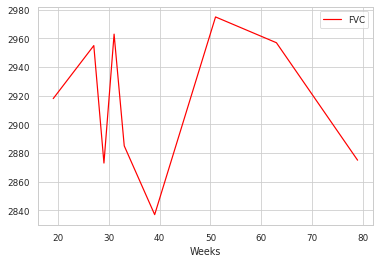

In [34]:
patient_01.plot(kind='line',x='Weeks',y='FVC',color='red')
plt.show()

plotting `Percent` over the weeks

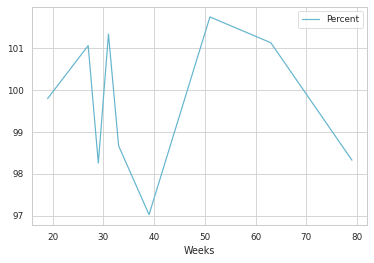

In [35]:
patient_01.plot(kind='line',x='Weeks',y='Percent', color='c')
plt.show()

And the same patient has `266` dicom images representing the slices of the CT scan acquired at `Week=0`

In [36]:
patient001 = train/'ID00082637202201836229724'
patient001_files = get_dicom_files(patient001)
patient001_files

(#266) [Path('../input/osic-pulmonary-fibrosis-progression/train/ID00082637202201836229724/89.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00082637202201836229724/32.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00082637202201836229724/251.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00082637202201836229724/3.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00082637202201836229724/261.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00082637202201836229724/87.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00082637202201836229724/67.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00082637202201836229724/28.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00082637202201836229724/259.dcm'),Path('../input/osic-pulmonary-fibrosis-progression/train/ID00082637202201836229724/85.dcm')...]

Customizing `show_images` so that it can take a `cmap` attribute. This can be easily done by using `@delegates`, the out of the box fastai version does not allow `cmap` as an option. `show_images` provides a convenient way of viewing mutiple images.

In [37]:
@delegates(subplots)
def show_images(ims, nrows=1, ncols=None, titles=None, cmap=None, **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    if ncols is None: ncols = int(math.ceil(len(ims)/nrows))
    if titles is None: titles = [None]*len(ims)
    axs = subplots(nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip(ims, titles, axs): show_image(im, ax=ax, title=t, cmap=cmap)

### Viewing the slices in chronological order

Let's view all the slices for this patient.  This is a multi-step process because we know from the `header` of the dicom file that tag **(0020, 0013) Instance Number** represents the chronological order of the slices of the CT scan.  Each file has a number so `file` 1 will be the first slice and the last file in the sequence will be the last slice.

The direction of the slices is represented in the diagram below so the first slice is from the bottom moving up the body

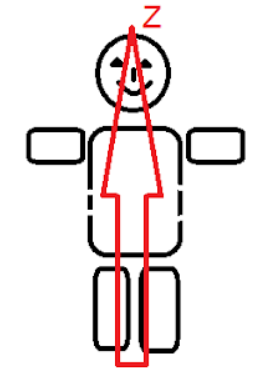

In [38]:
im_list = []

To be able to view all the images we need to create a custom function that will create a `PILDicom` image and for `show_images` to work we will iterate through all the images in the patients folder and append them to `im_list`.

In [39]:
def get_files(pat):
        folder = f'{train}/{pat}'
        fl = get_dicom_files(folder)
        for file in fl:
            im_list.append(file)

In [40]:
get_files('ID00082637202201836229724')

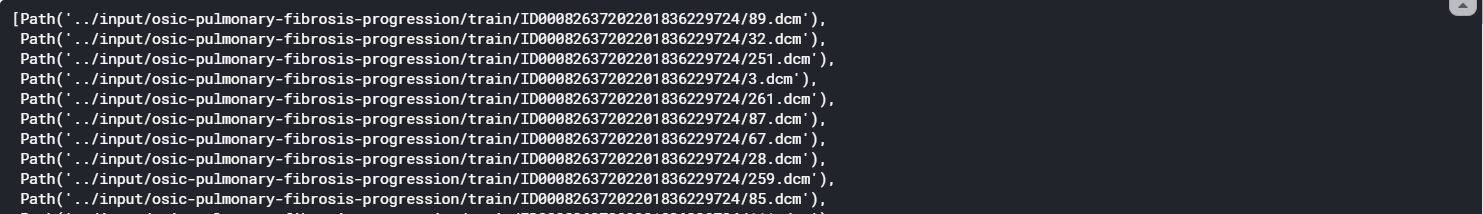

We notice that the images in the list are not in sequence so we need to put them in sequence using a `lamba` function

In [41]:
sorted_list = sorted(im_list, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))

That's better the file names are now in sequence

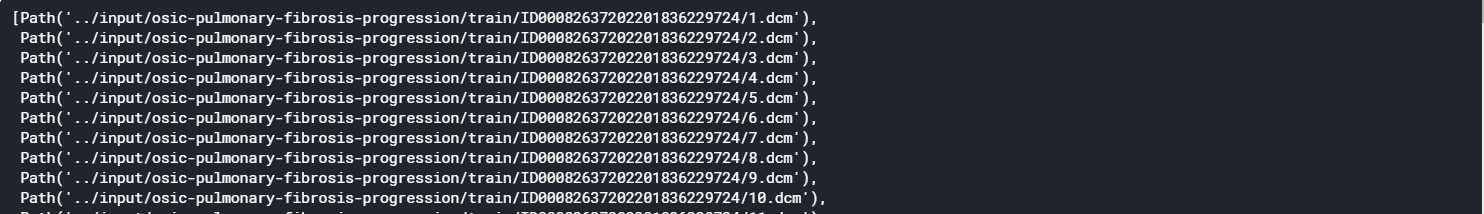

In [42]:
pat_list =[]

Now to view the images. `show_images` provides a convenient way of viewing mutiple images.

In [43]:
def view_patient(l):
    for file in l:
        trans = Transform(Resize(256))
        dicom_create = PILDicom.create(file)
        dicom_transform = trans(dicom_create)
        pat_list.append(dicom_transform)
    show_images(pat_list, cmap='bone', nrows=38)

The images are now in chronological order

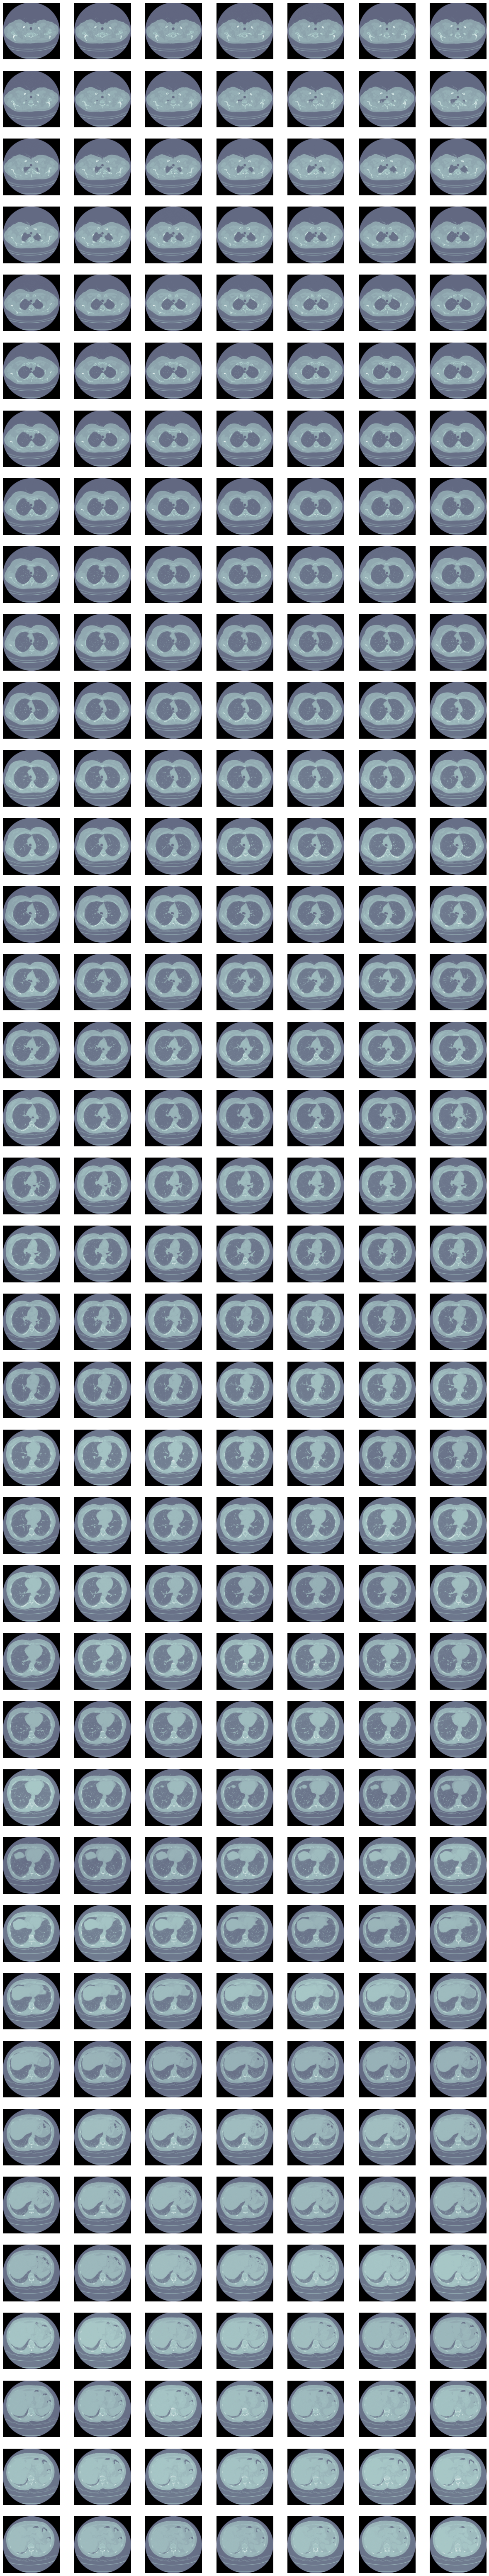

In [44]:
view_patient(sorted_list)